In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from pymer4.models import Lmer,Lm
from matplotlib import cm
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.patches as mpatches
import seaborn as sns



In [3]:
pd.set_option('display.max_columns', None)

In [4]:
concatenated_df = pd.read_pickle('./concatenated_df_oct.pkl')
age = pd.read_pickle('./age_oct.pkl')


average age: 30.741868131868134
average age controls: 35.067391304347844
average age encephalitis: 28.807199999999998
average age schizophrenia: 23.2115


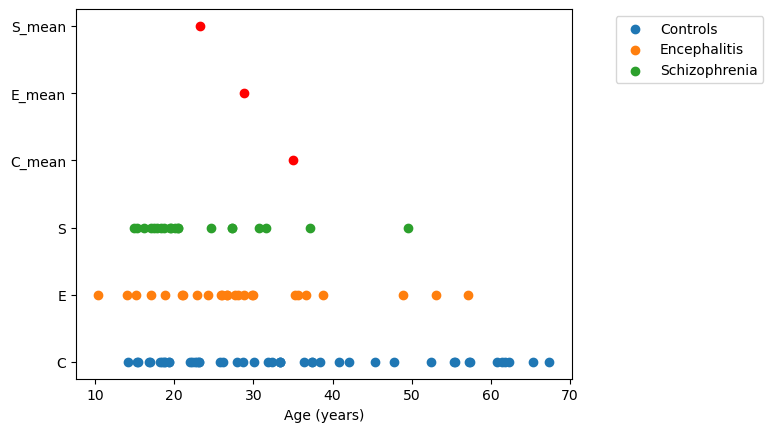

In [5]:
age['Group'] = age['Subject'].str[0]
age.tail(9)


# Session 1
print('average age:', np.mean(age.loc[age['Session']==1, 'Age']))
print('average age controls:', np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']))
print('average age encephalitis:', np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']))
print('average age schizophrenia:', np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']))

# plot age
plt.scatter(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='C')&(age['Session']==1)), 'Group'], label = 'Controls')
plt.scatter(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='E')&(age['Session']==1)), 'Group'], label = 'Encephalitis')
plt.scatter(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='S')&(age['Session']==1)), 'Group'], label = 'Schizophrenia')
plt.legend(bbox_to_anchor=(1.4, 1.0))
  
plt.errorbar(np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), "C_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']), "E_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')
plt.errorbar(np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']), "S_mean", xerr=stats.sem(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']), marker="o", color = 'r')

plt.xlabel('Age (years)')
plt.savefig('Age variance', bbox_inches='tight')
plt.show()




In [6]:
def fill_na_mode(group):
    mode = group.mode()
    if len(mode) > 0:
        return group.fillna(mode.iloc[0])
    else:
        return group

age['sex'] = age.groupby('Subject')['M/F'].transform(fill_na_mode)


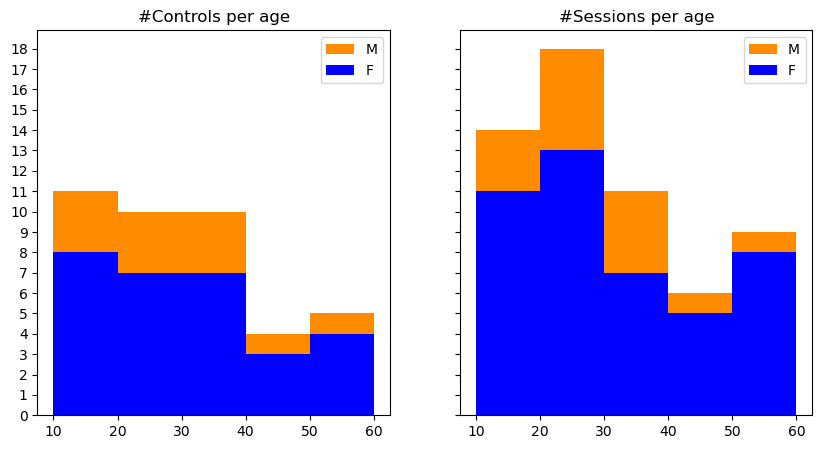

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5), sharex = 'all', sharey = 'all')


ax[0].hist(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'],color='darkorange',bins=[10, 20, 30, 40, 50, 60], label = 'M')
ax[0].hist(age.loc[((age['Group']=='C')&(age['Session']==1)&(age['sex']=='F')), 'Age'], color = 'blue',bins=[10, 20, 30, 40, 50, 60], label = 'F')
ax[0].set_yticks(np.arange(0, 20, step=1))
ax[0].legend()
ax[0].set_title('#Controls per age')

ax[1].hist(age.loc[((age['Group']=='C')), 'Age'],bins=[10, 20, 30, 40, 50, 60],color='darkorange', label = 'M')
ax[1].hist(age.loc[((age['Group']=='C')&(age['sex']=='F')), 'Age'], color = 'blue',bins=[10, 20, 30, 40, 50, 60], label = 'F')
ax[1].legend()
ax[1].set_title('#Sessions per age')

plt.show()


In [8]:
# Subsets data
crs1 = concatenated_df['Session']==1
crs2 = concatenated_df['Session']==2
crs3 = concatenated_df['Session']==3
crs4 = concatenated_df['Session']==4

cri1 = concatenated_df['Group'] == 'C'
cri2 = concatenated_df['Group'] == 'E'
cri3 = concatenated_df['Group'] == 'S'
criC = cri1 & crs1
criE = cri2 & crs1
criS = cri3 & crs1

# Only data from session 1
#data = concatenated_df[crs1]
data=concatenated_df

# Add confusional arousals
cfsubj = ['E02','E03','E05','E06','E07','E16','E21','E22','C11','C12','C14','C18']
data['ConfArousal'] = 0
data.loc[concatenated_df.Subject.isin(cfsubj),'ConfArousal'] = 1
data.loc[:,'ConfArousal'] = data.loc[:,'ConfArousal'].astype('category')


# select frontal and posterior channels
chan_fp = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F8', 'F3','Fz', 'F4', 'F8', 'P3', 'Pz', 'P4', 'PO7', 'PO3', 
           'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
data_fp = concatenated_df[concatenated_df.Channel.isin(chan_fp)]

# add column indicating whether frontal or posterior electrode
#chan_f = ['Fz','F3','F4']
chan_f = ['Fz','F3','F4','F7','F8']
data_fp['Position'] = 'P'
data_fp.loc[data_fp.Channel.isin(chan_f),'Position'] = 'F'
data_fp.loc[:,'Session'] = data_fp.loc[:,'Session'].astype(int)


/tmp/ipykernel_609574/3263902381.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fp['Position'] = 'P'


## AGE COMPRISON between 20- and 20+

In [9]:
data_F = data_fp.copy()
data_F = data_F[data_F['Position'] == 'F'].reset_index(drop=True)
data_F.head()

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel,Group,Subject,Session,Age,Machine,ConfArousal,Position
0,16147,0.390689,1406.81,1407.16,1407.77,1408.12,1.64,-54.438037,56.538966,110.977003,317.077151,0.609756,2,F4,9,C,C02,1,22.91,O,0,F
1,11458,0.391044,1408.03,1408.31,1408.67,1409.26,1.50,-59.791872,41.681846,101.473718,362.406135,0.666667,2,F7,6,C,C02,1,22.91,O,0,F
2,14355,0.393181,1415.75,1416.35,1416.68,1416.93,1.48,-43.574775,38.377907,81.952683,136.587804,0.675676,2,Fz,8,C,C02,1,22.91,O,0,F
3,11459,0.393536,1417.03,1417.28,1417.47,1417.69,0.96,-82.223783,45.544797,127.768579,511.074318,1.041667,2,F7,6,C,C02,1,22.91,O,0,F
4,14356,0.397639,1431.74,1431.96,1432.18,1432.82,1.32,-42.860329,34.949432,77.809761,353.680731,0.757576,2,Fz,8,C,C02,1,22.91,O,0,F


In [10]:
data_F[data_F['Stage'] == 3]['Start']

47        0.673000
48        0.679381
49        0.679381
50        0.679381
51        0.679381
            ...   
843546    5.718425
843547    5.722625
843548    5.722628
843549    5.722950
843737    6.576497
Name: Start, Length: 559209, dtype: float64

In [11]:
data_F['Start']

0         0.390689
1         0.391044
2         0.393181
3         0.393536
4         0.397639
            ...   
844182    7.966611
844183    7.966636
844184    7.971547
844185    7.982069
844186    7.982247
Name: Start, Length: 844187, dtype: float64

In [12]:
data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

In [13]:
data_prov = data_F[data_F['Id']=='E18_1']
data_prov = data_prov[data_prov['Stage']==3]
data_prov

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel,Group,Subject,Session,Age,Machine,ConfArousal,Position,Id
604345,6710,0.371167,1336.47,1336.70,1336.92,1337.25,1.05,-58.338019,48.150222,106.488242,462.992356,0.952381,3,Fz,8,E,E18,1,25.91,N,0,F,E18_1
604346,5625,0.371175,1336.49,1336.72,1336.93,1337.24,1.01,-55.085696,45.797556,100.883251,438.622832,0.990099,3,F3,7,E,E18,1,25.91,N,0,F,E18_1
604347,8002,0.371178,1336.49,1336.72,1336.92,1337.17,0.93,-56.757571,36.740741,93.498312,406.514399,1.075269,3,F4,9,E,E18,1,25.91,N,0,F,E18_1
604348,5277,0.377364,1358.78,1359.03,1359.22,1359.96,1.45,-60.205166,32.563511,92.768677,371.074707,0.689655,3,F7,6,E,E18,1,25.91,N,0,F,E18_1
604349,8003,0.377375,1358.80,1359.05,1359.24,1359.98,1.43,-63.795980,30.869668,94.665648,378.662592,0.699301,3,F4,9,E,E18,1,25.91,N,0,F,E18_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607553,6575,3.968572,14287.11,14287.35,14287.61,14287.93,1.07,-97.759993,78.960425,176.720418,736.335075,0.934579,3,F3,7,E,E18,1,25.91,N,0,F,E18_1
607554,8765,3.968572,14287.10,14287.35,14287.60,14288.03,1.17,-58.026169,35.295716,93.321885,373.287538,0.854701,3,F4,9,E,E18,1,25.91,N,0,F,E18_1
607555,7832,3.968575,14287.10,14287.35,14287.67,14288.04,1.17,-86.413366,60.976577,147.389942,589.559770,0.854701,3,Fz,8,E,E18,1,25.91,N,0,F,E18_1
607556,5561,3.968594,14287.17,14287.41,14287.67,14287.99,1.05,-52.979018,50.911554,103.890572,432.877383,0.952381,3,F7,6,E,E18,1,25.91,N,0,F,E18_1


data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)
data_F['time_n'] = data_F['Start']
time_threshold = 0.005
slope_threshold = 0.20

def filter_group(group):
    tree = cKDTree(group[['time_n', 'Slope']])
    pairs = tree.query_pairs(r=np.sqrt(time_threshold**2 + slope_threshold**2))
    keep = np.ones(len(group), dtype=bool)
    for i, j in pairs:
        keep[j] = False
    return group[keep]

data_F = data_F.groupby('Id', group_keys=False).apply(filter_group).drop(columns=['time_n']).reset_index(drop=True)


(0.0, 1.0)

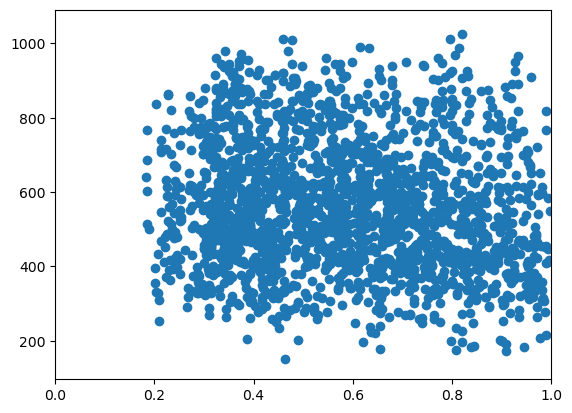

In [14]:
data_prov = data_F[data_F['Id']=='C47_1']
plt.scatter(data_prov['Start'],data_prov['Slope'])
plt.xlim([0,1])

In [15]:
data_F.groupby('Id')

In [16]:

def find_next_bigger(sorted_array, value1):
    for num in sorted_array:
        if num > value1:
            return num
    
    return None

def first_block_all(data, data_n3, bin_size, threshold_sum,id):
    if len(data_n3) < threshold_sum:
         return None

    hist_values, bin_edges = np.histogram(data, bins=np.arange(0, round(max(data),2) + bin_size, bin_size))
    hist_valuesn3, bin_edgesn3 = np.histogram(data_n3, bins=np.arange(0, round(max(data_n3),2) + bin_size, bin_size))

    nz_indices = np.where(hist_values > 10)[0]
    nz_indices3 = np.where(hist_valuesn3 > 5)[0]

    nz_edges = np.round(bin_edges[nz_indices],2)
    nz_edges3 = np.round(bin_edgesn3[nz_indices3],2)

    cbins = [nz_edges3[0]]
    if id == 'C07_1':
        print(nz_edges)

    if nz_edges[0] > cbins[0]:
        nz_edges = np.concatenate(([cbins[0]], nz_edges))

    for i in range(1, len(nz_edges)): 
        if nz_edges[i] in nz_edges3 or nz_edges[i] > cbins[0]:
            if round(nz_edges[i] - nz_edges[i - 1],2) == bin_size:
                if id == 'C07_1':
                 print(nz_edges[i])
                cbins.append(nz_edges[i])
            else:
                if (sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum):
                    if id == 'C07_1':
                        print(cbins)
                        print(sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]))
                    return cbins[0]

                if nz_edges[i] in nz_edges3:
                    cbins = [nz_edges[i]]
                else:
                    if find_next_bigger(nz_edges3, nz_edges[i]) is not None:
                        cbins = [find_next_bigger(nz_edges3, nz_edges[i])]
                    else:
                        return None

    if sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]) > threshold_sum:
                if id == 'C07_1':
                        print(cbins)
                        print(sum(hist_values[np.searchsorted(bin_edges, cbins[0]):np.searchsorted(bin_edges, cbins[-1])]))
                return cbins[0]
    return None



data_starts = data_F.groupby('Id').apply(
    lambda x: first_block_all(
        data=x['Start'],
        data_n3=x[x['Stage'] == 3]['Start'],
        bin_size=0.05,
        threshold_sum=250,
        id = x['Id'].values[0]
    )
).reset_index(name='Start_Block')




[0.85 0.9  0.95 1.   1.05 1.1  1.2  1.25 1.45 2.25 2.3  2.4  2.45 2.5
 2.55 2.65 3.55 3.95 4.75 4.8  4.85 6.25 6.3  6.35 6.4  6.45 6.5  6.55
 6.6 ]
0.9
0.95
1.0
1.05
1.1
2.3
2.45
2.5
2.55
4.8
4.85
6.3
6.35
6.4
6.45
6.5
6.55
6.6
[6.3, 6.3, 6.35, 6.4, 6.45, 6.5, 6.55, 6.6]
289


In [17]:
data_starts[data_starts['Id']=='C07_1']

,Id,Start_Block
7,C07_1,6.3


In [18]:
data_F

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel,Group,Subject,Session,Age,Machine,ConfArousal,Position,Id
0,16147,0.390689,1406.81,1407.16,1407.77,1408.12,1.64,-54.438037,56.538966,110.977003,317.077151,0.609756,2,F4,9,C,C02,1,22.91,O,0,F,C02_1
1,11458,0.391044,1408.03,1408.31,1408.67,1409.26,1.50,-59.791872,41.681846,101.473718,362.406135,0.666667,2,F7,6,C,C02,1,22.91,O,0,F,C02_1
2,14355,0.393181,1415.75,1416.35,1416.68,1416.93,1.48,-43.574775,38.377907,81.952683,136.587804,0.675676,2,Fz,8,C,C02,1,22.91,O,0,F,C02_1
3,11459,0.393536,1417.03,1417.28,1417.47,1417.69,0.96,-82.223783,45.544797,127.768579,511.074318,1.041667,2,F7,6,C,C02,1,22.91,O,0,F,C02_1
4,14356,0.397639,1431.74,1431.96,1432.18,1432.82,1.32,-42.860329,34.949432,77.809761,353.680731,0.757576,2,Fz,8,C,C02,1,22.91,O,0,F,C02_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844182,18543,7.966611,28680.11,28680.40,28680.63,28681.26,1.46,-116.404911,63.626076,180.030987,620.796507,0.684932,2,F7,6,S,S22,1,18.30,N,0,F,S22_1
844183,29095,7.966636,28680.17,28680.46,28680.70,28681.07,1.18,-50.067150,27.750825,77.817975,268.337845,0.847458,2,F8,10,S,S22,1,18.30,N,0,F,S22_1
844184,27450,7.971547,28698.09,28698.40,28698.71,28699.28,1.71,-94.930981,79.295763,174.226745,562.021757,0.584795,2,F4,9,S,S22,1,18.30,N,0,F,S22_1
844185,24612,7.982069,28736.41,28736.68,28736.87,28737.16,1.71,-75.461099,42.263394,117.724493,436.016639,0.584795,2,Fz,8,S,S22,1,18.30,N,0,F,S22_1


data_F = data_F[data_F.Id != 'E17_1']
data_F = data_F[data_F.Id != 'C07_4']
data_F = data_F[data_F.Id != 'E07_1']
data_F = data_F[data_F.Id != 'E02_3']
data_F = data_F[data_F.Id != 'E24_1']

In [19]:
data_F['N23_times'] = data_F['Id'].map(data_starts.set_index('Id')['Start_Block'])
data_F = data_F.dropna(subset=['N23_times'])
data_F['time_rel'] = data_F['Start'] - data_F['N23_times']
data_F = data_F[data_F['time_rel'] >= 0]

data_F['N3_times'] = data_F['Start'].where(data_F['Stage'] == 3)
N3_start_time = data_F.groupby(['Subject','Session'])['N3_times'].transform('min')

data_F['N3_times'] = N3_start_time

#############################################################################

data_F.loc[data_F['Id'] == 'C03_4', 'N3_times'] += 0.05
data_F.loc[data_F['Id'] == 'C04_1', 'N3_times'] += 0.1
data_F.loc[data_F['Id'] == 'C06_1', 'N3_times'] += 0.02
data_F.loc[data_F['Id'] == 'C14_1', 'N3_times'] += 0.23

##############################################################################


data_F['time_rel'] = data_F['Start'] - data_F['N3_times']
data_F['diff'] = data_F['N3_times'] - data_F['N23_times']

data_allF = data_F[(data_F['time_rel'] <= 0.5) & (data_F['time_rel'] >= 0)]
#data_allF = data_allF[(data_allF['Stage'] == 3) | (data_allF['time_rel'] >= 0.2)]

data_allF = data_allF.dropna(subset=['Age'])

/tmp/ipykernel_609574/1461330469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_F['time_rel'] = data_F['Start'] - data_F['N23_times']


In [20]:
#####################################################################################################

data_allF = data_allF[~((data_allF['time_rel'] > 0.4) & (data_allF['Id'] == 'C02_1'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.3) & (data_allF['Id'] == 'C03_1'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.4) & (data_allF['Id'] == 'C05_4'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.3) & (data_allF['Id'] == 'C07_1'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.3) & (data_allF['Id'] == 'C09_1'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.45) & (data_allF['Id'] == 'C13_4'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.38) & (data_allF['Id'] == 'C15_4'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.42) & (data_allF['Id'] == 'C14_4'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.4) & (data_allF['Id'] == 'C38_1'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.3) & (data_allF['Id'] == 'C16_1'))]

##################################################################################################

data_allF = data_allF[~((data_allF['time_rel'] > 0.4) & (data_allF['Id'] == 'E07_1'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.35) & (data_allF['Id'] == 'E07_2'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.4) & (data_allF['Id'] == 'E07_3'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.4) & (data_allF['Id'] == 'E08_3'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.4) & (data_allF['Id'] == 'E10_3'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.25) & (data_allF['Id'] == 'E15_4'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.3) & (data_allF['Id'] == 'E17_1'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.4) & (data_allF['Id'] == 'E17_3'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.35) & (data_allF['Id'] == 'E20_2'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.35) & (data_allF['Id'] == 'E25_1'))]

##############################################################################################

data_allF = data_allF[~((data_allF['time_rel'] > 0.4) & (data_allF['Id'] == 'S15_4'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.3) & (data_allF['Id'] == 'S16_1'))]
data_allF = data_allF[~((data_allF['time_rel'] > 0.3) & (data_allF['Id'] == 'S13_1'))]

In [21]:
data_allF.head()

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel,Group,Subject,Session,Age,Machine,ConfArousal,Position,Id,N23_times,time_rel,N3_times,diff
55,14366,0.711431,2561.41,2561.65,2561.89,2562.17,1.02,-43.055807,39.801527,82.857334,345.238892,0.980392,3,Fz,8,C,C02,1,22.91,O,0,F,C02_1,0.7,0.000000,0.711431,0.011431
56,16157,0.711439,2561.44,2561.67,2561.92,2562.21,1.03,-41.747439,44.001763,85.749202,372.822617,0.970874,3,F4,9,C,C02,1,22.91,O,0,F,C02_1,0.7,0.000008,0.711431,0.011431
57,11472,0.718289,2586.16,2586.47,2586.69,2587.44,1.60,-67.717177,20.232169,87.949346,283.707569,0.625000,3,F7,6,C,C02,1,22.91,O,0,F,C02_1,0.7,0.006858,0.711431,0.011431
58,12771,0.718289,2586.20,2586.51,2586.74,2587.45,1.61,-103.667240,46.635767,150.303006,484.848408,0.621118,3,F3,7,C,C02,1,22.91,O,0,F,C02_1,0.7,0.006858,0.711431,0.011431
59,16158,0.718289,2586.21,2586.55,2586.80,2587.41,1.57,-91.779559,43.404657,135.184215,397.600633,0.636943,3,F4,9,C,C02,1,22.91,O,0,F,C02_1,0.7,0.006858,0.711431,0.011431


data_F['Id'] = data_F['Subject'] + '_' + data_F['Session'].astype(str)

data_F['condBlock'] = 0
for index, row in data_F.iterrows():
    if row['Stage'] == 3:
        t0 = row['Start']
        t0_5 = t0 + 0.5
        id = row['Id']
        data_Id = data_F.where(data_F['Id'] == id)
        data_Id['N3'] = data_Id['Stage'].apply(lambda x: 1 if x == 3 else 0)
        c = data_Id[(data_Id['Start'] > t0) & (data_Id['Start'] <= t0_5)] 
        c = c['N3'].eq(1).sum()
        if c >= 100:
            row['condBlock'] = 1

In [22]:
result_df = data_allF.groupby('Id')['diff'].first().reset_index()
result_df[0:60]



,Id,diff
0,C02_1,0.011431
1,C03_1,0.024964
2,C03_4,0.086644
3,C04_1,0.104475
4,C05_4,0.009331
5,C06_1,0.023678
6,C06_4,0.008653
7,C07_1,0.021239
8,C07_4,0.043039
9,C08_1,0.036106


In [23]:
data_18_3 = data_allF[data_allF['Stage']==3]
data_18_3[data_18_3['Id']=='E18_4']['Start']

614554    2.004731
614555    2.004733
614556    2.004733
614561    2.019342
614562    2.021253
            ...   
615033    2.496919
615034    2.496922
615035    2.496928
615036    2.496931
615037    2.499419
Name: Start, Length: 475, dtype: float64

In [24]:
result_df = data_allF.groupby('Id')['N3_times'].first().reset_index()
result_df[75:125]


,Id,N3_times
75,E08_1,0.531303
76,E08_2,0.550578
77,E08_3,0.525603
78,E08_4,0.761581
79,E09_1,4.111439
80,E09_3,3.252817
81,E09_4,0.908353
82,E10_3,1.083822
83,E10_4,1.038361
84,E11_1,0.279928


In [25]:
data_allF[data_allF['Id'] == 'C02_1'].head(9)

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel,Group,Subject,Session,Age,Machine,ConfArousal,Position,Id,N23_times,time_rel,N3_times,diff
55,14366,0.711431,2561.41,2561.65,2561.89,2562.17,1.02,-43.055807,39.801527,82.857334,345.238892,0.980392,3,Fz,8,C,C02,1,22.91,O,0,F,C02_1,0.7,0.000000,0.711431,0.011431
56,16157,0.711439,2561.44,2561.67,2561.92,2562.21,1.03,-41.747439,44.001763,85.749202,372.822617,0.970874,3,F4,9,C,C02,1,22.91,O,0,F,C02_1,0.7,0.000008,0.711431,0.011431
57,11472,0.718289,2586.16,2586.47,2586.69,2587.44,1.60,-67.717177,20.232169,87.949346,283.707569,0.625000,3,F7,6,C,C02,1,22.91,O,0,F,C02_1,0.7,0.006858,0.711431,0.011431
58,12771,0.718289,2586.20,2586.51,2586.74,2587.45,1.61,-103.667240,46.635767,150.303006,484.848408,0.621118,3,F3,7,C,C02,1,22.91,O,0,F,C02_1,0.7,0.006858,0.711431,0.011431
59,16158,0.718289,2586.21,2586.55,2586.80,2587.41,1.57,-91.779559,43.404657,135.184215,397.600633,0.636943,3,F4,9,C,C02,1,22.91,O,0,F,C02_1,0.7,0.006858,0.711431,0.011431
60,17692,0.718289,2586.19,2586.53,2586.87,2587.36,1.52,-49.231720,26.332969,75.564689,222.249086,0.657895,3,F8,10,C,C02,1,22.91,O,0,F,C02_1,0.7,0.006858,0.711431,0.011431
61,16159,0.722950,2602.98,2603.20,2603.48,2603.80,1.18,-62.086992,91.715645,153.802637,699.102896,0.847458,3,F4,9,C,C02,1,22.91,O,0,F,C02_1,0.7,0.011519,0.711431,0.011431
62,14367,0.728472,2622.79,2623.03,2623.25,2623.97,1.47,-45.009583,36.084354,81.093936,337.891401,0.680272,3,Fz,8,C,C02,1,22.91,O,0,F,C02_1,0.7,0.017042,0.711431,0.011431
63,16160,0.730631,2630.59,2630.83,2631.04,2631.30,1.03,-90.122824,65.240226,155.363050,647.346042,0.970874,3,F4,9,C,C02,1,22.91,O,0,F,C02_1,0.7,0.019200,0.711431,0.011431


In [26]:

#SEPARATE BINNED DATA_F in 20- and 20+

bins_data_F = data_allF.copy()
bins_data_F = bins_data_F[bins_data_F['Session']==1]
bins_data_F['time_rel'] = pd.cut(bins_data_F['time_rel'], bins=8)  # Adjust the number of bins as needed


print (len(bins_data_F))

#older group
bdf_o = bins_data_F[bins_data_F['Age'] > 18]
print(len(bdf_o))

bdf_o = bdf_o.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_o['Group'] = bdf_o['Subject'].str[0]
mdf_o = bdf_o.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()

#younger group
bdf_y = bins_data_F[bins_data_F['Age'] <= 18]
print(len(bdf_y))

bdf_y = bdf_y.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bdf_y['Group'] = bdf_y['Subject'].str[0]
mdf_y = bdf_y.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()

#all
bins_data_F = bins_data_F.groupby(['Session','Subject','time_rel'])['Slope'].mean().reset_index()
bins_data_F['Group'] = bins_data_F['Subject'].str[0]
mean_data_F = bins_data_F.groupby(['Group','time_rel'])['Slope'].agg(['mean', 'sem']).reset_index()


100126
71795
28331


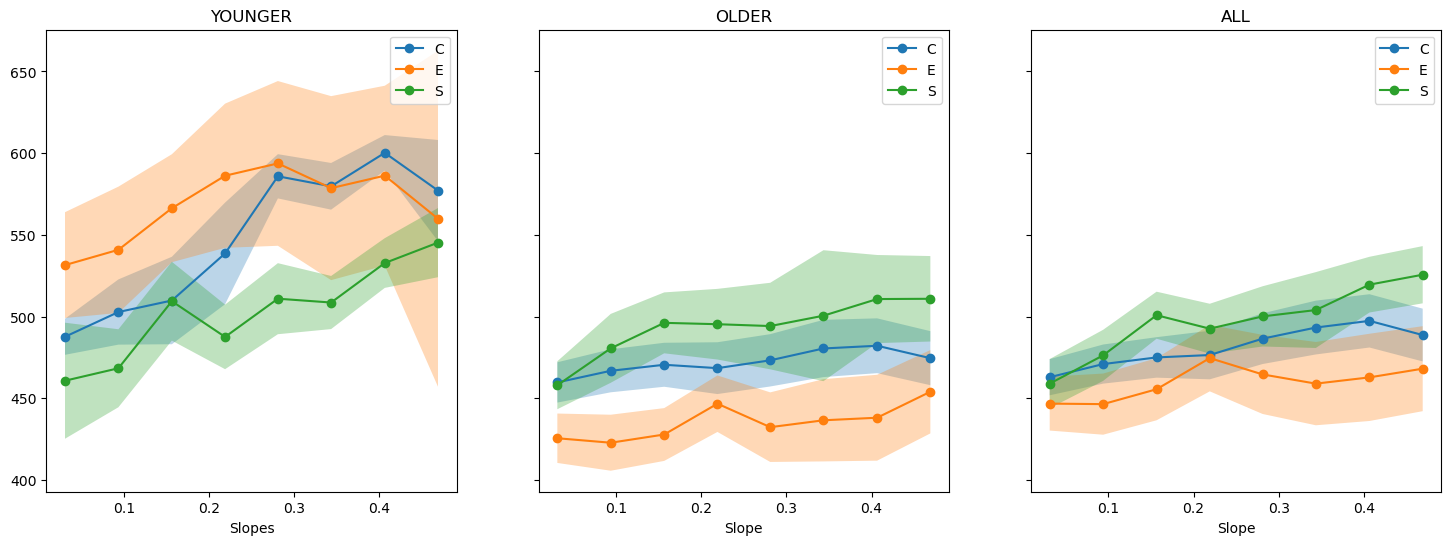

In [27]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6), sharex = 'all', sharey = 'all')

# Plot the individual curves for each name
mdf_o["time_rel_c"] = mdf_o["time_rel"].apply(lambda x: x.mid)
mdf_y["time_rel_c"] = mdf_y["time_rel"].apply(lambda x: x.mid)
mean_data_F["time_rel_c"] = mean_data_F["time_rel"].apply(lambda x: x.mid)
time_intervals = mdf_o['time_rel_c'].unique()

#YOUNGER
ax[0].set_title('YOUNGER')
for name, group in mdf_y.groupby('Group'):
    ax[0].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[0].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[0].set_xlabel('Time')
ax[0].set_xlabel('Slopes')
ax[0].legend()

#OLDER
ax[1].set_title('OLDER')
for name, group in mdf_o.groupby('Group'):
    ax[1].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[1].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[1].set_xlabel('Time')
ax[1].set_xlabel('Slope')
ax[1].legend()

#ALL
ax[2].set_title('ALL')
for name, group in mean_data_F.groupby('Group'):
    ax[2].plot(time_intervals, group['mean'], marker='o', label=name)
    ax[2].fill_between(time_intervals, group['mean'] - group['sem'],
                     group['mean'] + group['sem'], alpha=0.3)

ax[2].set_xlabel('Time')
ax[2].set_xlabel('Slope')
ax[2].legend()



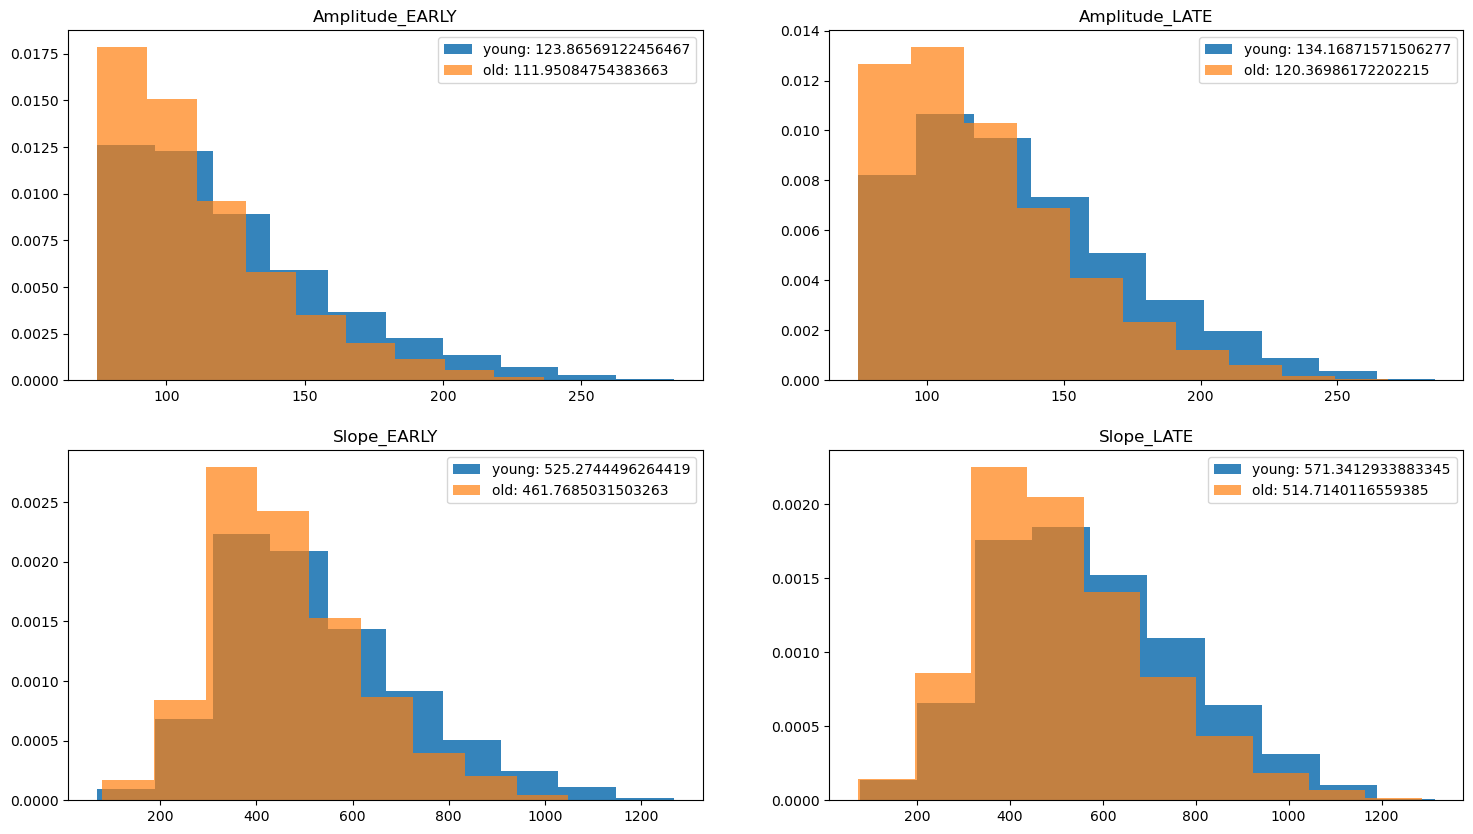

In [28]:
fig, ax = plt.subplots(2, 2, figsize = (18, 10))

data_young = data_allF[data_allF['Age'] < 20]
data_old = data_allF[data_allF['Age'] >= 20]


data_early_young = data_young[data_young['time_rel'] <= 0.15]
data_late_young = data_young[data_young['time_rel'] >= 0.35]
data_early_old = data_old[data_old['time_rel'] <= 0.1]
data_late_old = data_old[data_old['time_rel'] >= 0.4]

ax[0,0].hist(data_early_young.PTP, density = True, alpha = 0.9, label = 'young: ' + str(np.mean(data_early_young.PTP)) )
ax[0,0].hist(data_early_old.PTP, density = True, alpha = 0.7, label = 'old: ' + str(np.mean(data_early_old.PTP)))
ax[0,0].set_title('Amplitude_EARLY')
ax[0,0].legend()

ax[0,1].hist(data_late_young.PTP, density = True, alpha = 0.9, label = 'young: ' + str(np.mean(data_late_young.PTP)) )
ax[0,1].hist(data_late_old.PTP, density = True, alpha = 0.7, label = 'old: ' + str(np.mean(data_late_old.PTP)))
ax[0,1].set_title('Amplitude_LATE')
ax[0,1].legend()

ax[1,0].hist(data_early_young.Slope, density = True, alpha = 0.9, label = 'young: ' + str(np.mean(data_early_young.Slope)) )
ax[1,0].hist(data_early_old.Slope, density = True, alpha = 0.7, label = 'old: ' + str(np.mean(data_early_old.Slope)))
ax[1,0].set_title('Slope_EARLY')
ax[1,0].legend()

ax[1,1].hist(data_late_young.Slope, density = True, alpha = 0.9, label = 'young: ' + str(np.mean(data_late_young.Slope)) )
ax[1,1].hist(data_late_old.Slope, density = True, alpha = 0.7, label = 'old: ' + str(np.mean(data_late_old.Slope)))
ax[1,1].set_title('Slope_LATE')
ax[1,1].legend()


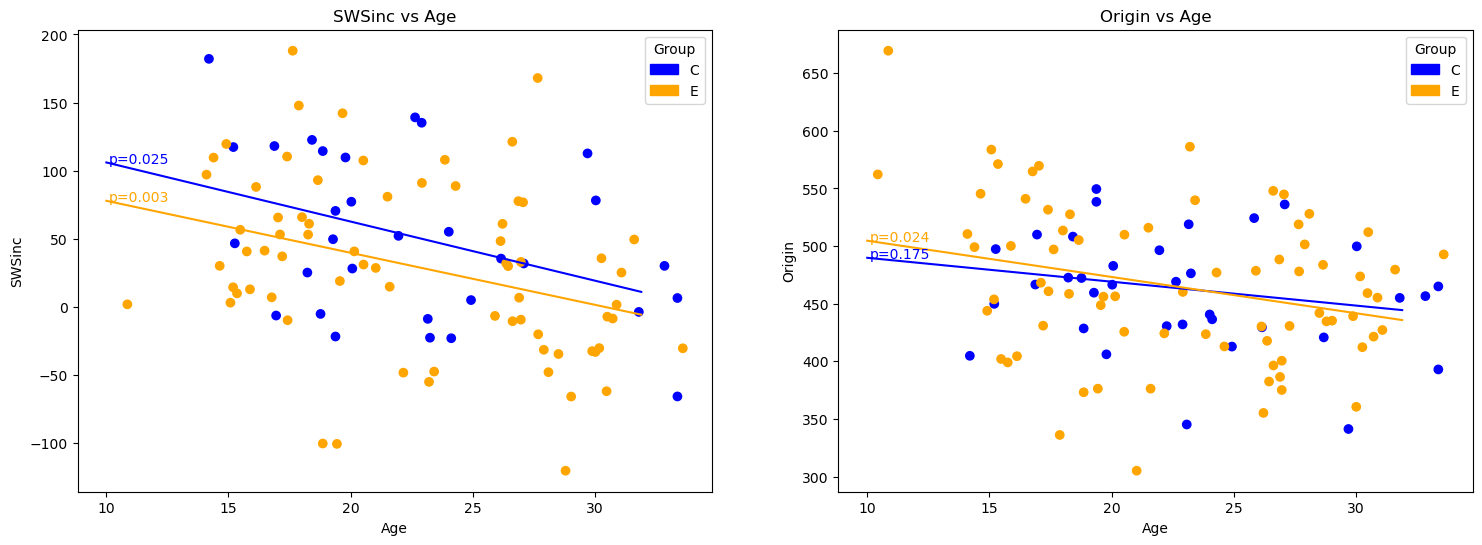

In [29]:


colors = {'C': 'blue', 'E': 'orange'}


df_tmp = data_allF[data_allF['Age']<35].copy()
df_tmp.loc[df_tmp['Group'] == 'S', 'Group'] = 'E'

swsinc_data = []
for name, Subject in df_tmp.groupby('Id'):
    subject_early = Subject[Subject['time_rel'] <= 0.05]
    subject_late = Subject[((Subject['time_rel'] > 0.3) & (Subject['time_rel'] <= 0.35))]
    diff_slope_s = subject_late['Slope'].mean() - subject_early['Slope'].mean()
    slope_origin = subject_early['Slope'].mean()
    age_s = Subject['Age'].iloc[0]
    group_s = Subject['Group'].iloc[0]
    swsinc_data.append({'Id': name, 'Age': age_s, 'SWSinc': diff_slope_s, 'Origin': slope_origin, 'Group': group_s})

df_swsinc = pd.DataFrame(swsinc_data)
color_map = df_swsinc['Group'].map(colors)


plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)


plt.scatter(df_swsinc['Age'], df_swsinc['SWSinc'], c=color_map)
plt.xlabel('Age')
plt.ylabel('SWSinc')
plt.title('SWSinc vs Age')

legend_patches = [mpatches.Patch(color=color, label=group) for group, color in colors.items()]
plt.legend(handles=legend_patches, title="Group")

for group in colors.keys():
    group_data = df_swsinc[df_swsinc['Group'] == group]
    group_data = group_data.dropna()
    if not group_data.empty:
        slope, intercept, r_value, p_value, std_err = stats.linregress(group_data['Age'], group_data['SWSinc'])
        
        x_vals = np.arange(10,32,0.1)
        y_vals = intercept + slope * x_vals
        if group == 'C':
            s18_c = intercept + slope * 18
        elif group == 'E':
            s18_e = intercept + slope * 18
        


        plt.plot(x_vals, y_vals, color=colors[group], label=f'{group} (p={p_value:.3f})')
        
        plt.annotate(f'p={p_value:.3f}', xy=(x_vals[1], y_vals[1]), color=colors[group], fontsize=10)


plt.subplot(1,2,2)

plt.scatter(df_swsinc['Age'], df_swsinc['Origin'], c=color_map)
plt.xlabel('Age')
plt.ylabel('Origin')
plt.title('Origin vs Age')

legend_patches = [mpatches.Patch(color=color, label=group) for group, color in colors.items()]
plt.legend(handles=legend_patches, title="Group")

for group in colors.keys():
    group_data = df_swsinc[df_swsinc['Group'] == group]
    group_data = group_data.dropna()
    if not group_data.empty:
        slope, intercept, r_value, p_value, std_err = stats.linregress(group_data['Age'], group_data['Origin'])
        
        x_vals = np.arange(10,32,0.1)
        y_vals = intercept + slope * x_vals
        if group == 'C':
            o18_c = intercept + slope * 18
        elif group == 'E':
            o18_e = intercept + slope * 18
        

        plt.plot(x_vals, y_vals, color=colors[group], label=f'{group} (p={p_value:.3f})')
        
        plt.annotate(f'p={p_value:.3f}', xy=(x_vals[1], y_vals[1]), color=colors[group], fontsize=10)

plt.show()

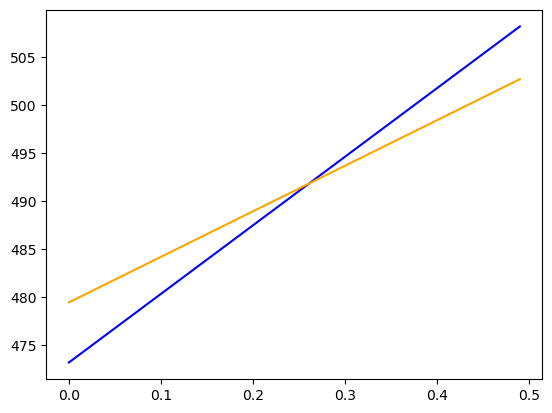

In [30]:
x_times = np.arange(0,0.5,0.01)

control_pred = o18_c + s18_c*x_times
patient_pred = o18_e + s18_e*x_times

plt.plot(x_times, control_pred, color = 'blue')
plt.plot(x_times, patient_pred, color = 'orange')

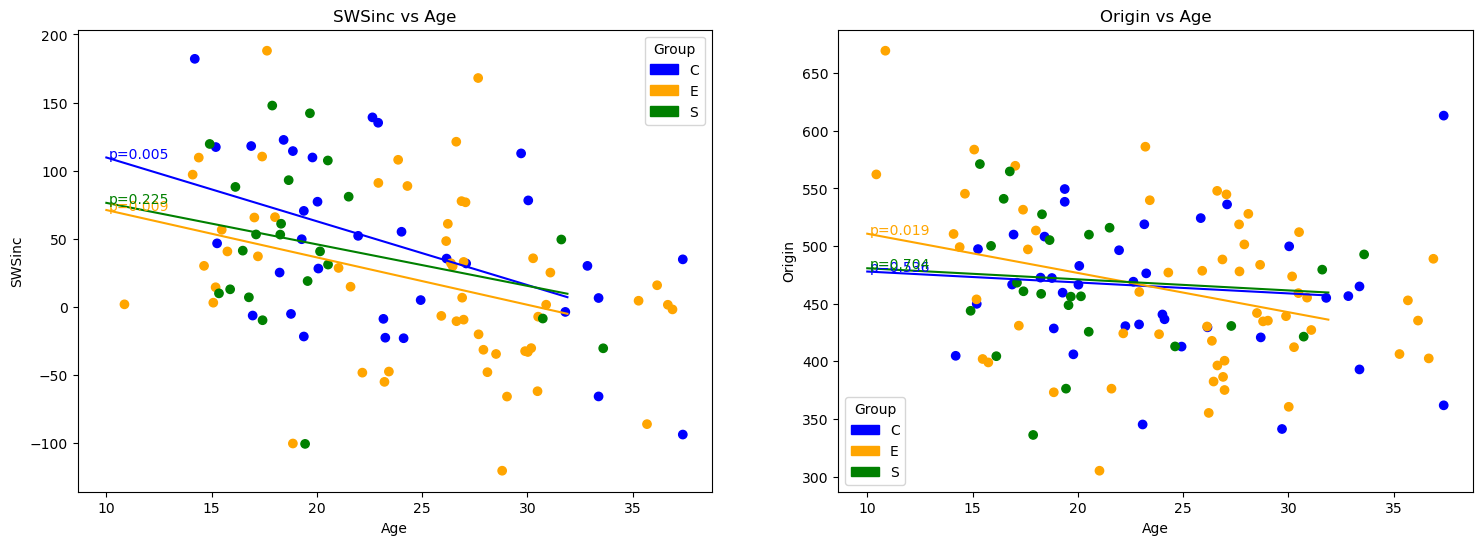

In [55]:


colors = {'C': 'blue', 'E': 'orange', 'S': 'green' }


swsinc_data = []
for name, Subject in df_tmp.groupby('Id'):
    subject_early = Subject[Subject['time_rel'] <= 0.05]
    subject_late = Subject[((Subject['time_rel'] > 0.3) & (Subject['time_rel'] <= 0.35))]
    diff_slope_s = subject_late['Slope'].mean() - subject_early['Slope'].mean()
    slope_origin = subject_early['Slope'].mean()
    age_s = Subject['Age'].iloc[0]
    group_s = Subject['Group'].iloc[0]
    swsinc_data.append({'Id': name, 'Age': age_s, 'SWSinc': diff_slope_s, 'Origin': slope_origin, 'Group': group_s})

df_swsinc = pd.DataFrame(swsinc_data)
color_map = df_swsinc['Group'].map(colors)

df_swsinc = pd.DataFrame(swsinc_data)
color_map = df_swsinc['Group'].map(colors)

plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)


plt.scatter(df_swsinc['Age'], df_swsinc['SWSinc'], c=color_map)
plt.xlabel('Age')
plt.ylabel('SWSinc')
plt.title('SWSinc vs Age')

legend_patches = [mpatches.Patch(color=color, label=group) for group, color in colors.items()]
plt.legend(handles=legend_patches, title="Group")

for group in colors.keys():
    group_data = df_swsinc[df_swsinc['Group'] == group]
    group_data = group_data.dropna()
    if not group_data.empty:
        slope, intercept, r_value, p_value, std_err = stats.linregress(group_data['Age'], group_data['SWSinc'])
        
        x_vals = np.arange(10,32,0.1)
        y_vals = intercept + slope * x_vals
        if group == 'C':
            s18_c = intercept + slope * 18
        elif group == 'E':
            s18_e = intercept + slope * 18
        elif group == 'S':
            s18_s = intercept + slope * 18
        
        plt.plot(x_vals, y_vals, color=colors[group], label=f'{group} (p={p_value:.3f})')
        
        plt.annotate(f'p={p_value:.3f}', xy=(x_vals[1], y_vals[1]), color=colors[group], fontsize=10)


plt.subplot(1,2,2)

plt.scatter(df_swsinc['Age'], df_swsinc['Origin'], c=color_map)
plt.xlabel('Age')
plt.ylabel('Origin')
plt.title('Origin vs Age')

legend_patches = [mpatches.Patch(color=color, label=group) for group, color in colors.items()]
plt.legend(handles=legend_patches, title="Group")

for group in colors.keys():
    group_data = df_swsinc[df_swsinc['Group'] == group]
    group_data = group_data.dropna()
    if not group_data.empty:
        slope, intercept, r_value, p_value, std_err = stats.linregress(group_data['Age'], group_data['Origin'])
        
        x_vals = np.arange(10,32,0.1)
        y_vals = intercept + slope * x_vals
        if group == 'C':
            o18_c = intercept + slope * 18
        elif group == 'E':
            o18_e = intercept + slope * 18
        elif group == 'S':
            o18_s = intercept + slope * 18
        plt.plot(x_vals, y_vals, color=colors[group], label=f'{group} (p={p_value:.3f})')
        
        plt.annotate(f'p={p_value:.3f}', xy=(x_vals[1], y_vals[1]), color=colors[group], fontsize=10)

plt.show()


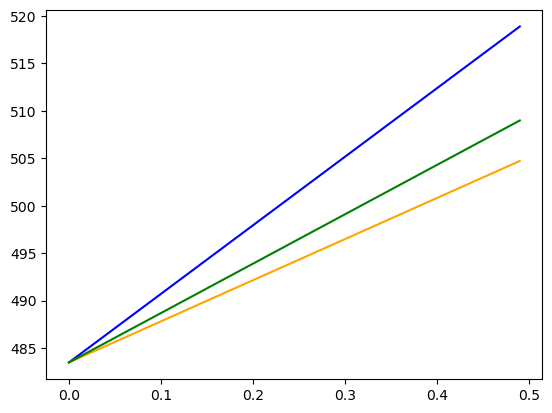

In [56]:
x_times = np.arange(0,0.5,0.01)

control_pred = o18_e + s18_c*x_times
enc_pred = o18_e + s18_e*x_times
sch_pred = o18_e + s18_s*x_times

plt.plot(x_times, control_pred, color = 'blue')
plt.plot(x_times, enc_pred, color = 'orange')
plt.plot(x_times, sch_pred, color = 'green')

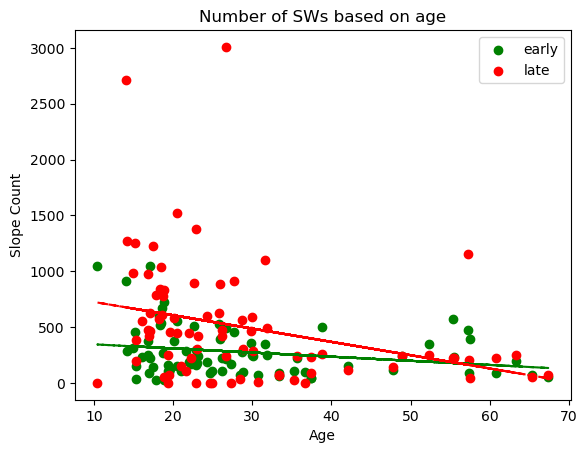

In [57]:

x_early_list = []
y_early_list = []
x_late_list = []
y_late_list = []

for name, Subject in data_allF.groupby('Subject'):
    data_early = Subject[Subject['time_rel'] <= 0.1]
    data_late = Subject[Subject['time_rel'] >= 0.4]

    x_early_list.append(Subject['Age'].unique()[0])
    y_early_list.append(data_early['Slope'].count())

    x_late_list.append(Subject['Age'].unique()[0])
    y_late_list.append(data_late['Slope'].count())

plt.scatter(x_early_list, y_early_list, marker='o', c='green', label='early')
plt.scatter(x_late_list, y_late_list, marker='o', c='red', label='late')

early_fit = np.polyfit(x_early_list, y_early_list, 1)
late_fit = np.polyfit(x_late_list, y_late_list, 1)

plt.plot(x_early_list, np.polyval(early_fit, x_early_list), color='green', linestyle='--')
plt.plot(x_late_list, np.polyval(late_fit, x_late_list), color='red', linestyle='--')

plt.title('Number of SWs based on age')
plt.xlabel('Age')
plt.ylabel('Slope Count')
plt.legend()
plt.show()



In [58]:
df_serial_bias_ext = pd.read_csv('Serial_biases_at_3seconds.csv')
df_serial_bias_ext = df_serial_bias_ext.rename(columns={'subject': 'Subject'})
df_serial_bias_ext = df_serial_bias_ext.rename(columns={'session': 'Session'})
len(df_serial_bias_ext)


68

In [59]:
age

,Subject,Session,Birthdate,Testdate,M/F,Age,Group,sex
0,C02,1,1994-05-28 00:00:00,2017-04-26 00:00:00,F,22.91,C,F
1,C03,1,1988-09-09 00:00:00,2017-05-18 00:00:00,F,28.69,C,F
2,C04,1,1987-05-24 00:00:00,2017-06-08 00:00:00,F,30.04,C,F
3,C06,1,2003-04-10 00:00:00,2017-06-22 00:00:00,F,14.20,C,F
4,C07,1,1994-06-05 00:00:00,2017-07-05 00:00:00,F,23.08,C,F
...,...,...,...,...,...,...,...,...
160,S07,4,2002-06-21 00:00:00,2019-03-28 00:00:00,NaN,16.77,S,NaN
161,S08,4,2003-05-09 00:00:00,2019-03-27 00:00:00,NaN,15.88,S,F
162,S11,4,2003-05-15 00:00:00,2019-11-07 00:00:00,NaN,16.48,S,M
163,S12,4,1998-03-04 00:00:00,2019-09-05 00:00:00,NaN,21.51,S,F


[]

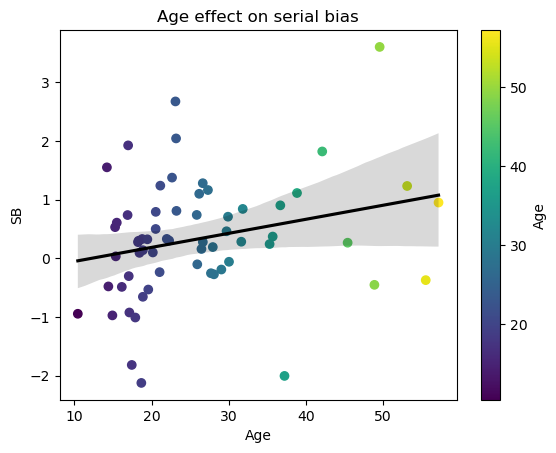

In [60]:
df_serial_bias_ext = df_serial_bias_ext.merge(age)
plt.scatter(df_serial_bias_ext['Age'],df_serial_bias_ext['SB'], c=df_serial_bias_ext['Age'], cmap='viridis')
plt.colorbar(label='Age')
sns.regplot(x='Age', y='SB', data=df_serial_bias_ext, scatter=False, color='black')
plt.title('Age effect on serial bias')
plt.plot()


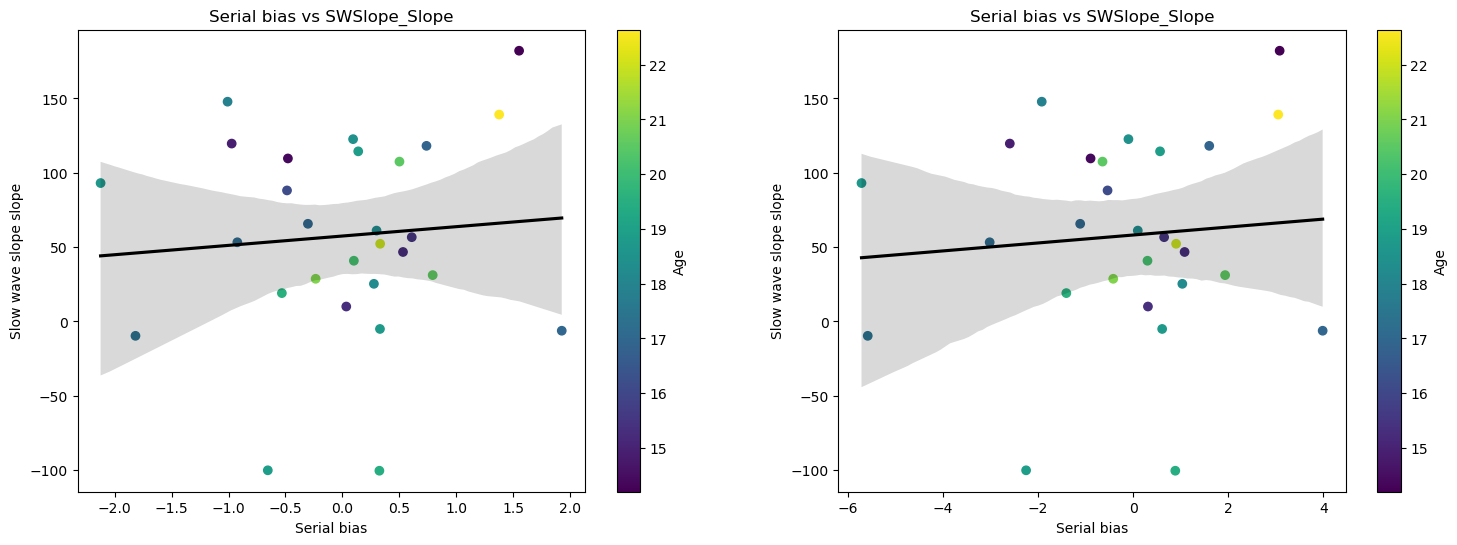

In [61]:
df_serial_bias_ext['Id'] = df_serial_bias_ext['Subject'] + '_' + df_serial_bias_ext['Session'].astype(str)
df_serial_age = pd.merge(df_serial_bias_ext, df_swsinc, on='Id', how='inner')
df_serial_age = df_serial_age[df_serial_age['Age_x']<23]
plt.figure(figsize=(18, 6))


plt.subplot(1,2,1)
plt.scatter(df_serial_age['SB'], df_serial_age['SWSinc'], c=df_serial_age['Age_x'], cmap='viridis')
plt.colorbar(label='Age')
sns.regplot(x='SB', y='SWSinc', data=df_serial_age, scatter=False, color='black')

plt.xlabel('Serial bias')
plt.ylabel('Slow wave slope slope')
plt.title('Serial bias vs SWSlope_Slope')

plt.subplot(1,2,2)
plt.scatter(df_serial_age['SB_par'], df_serial_age['SWSinc'], c=df_serial_age['Age_x'], cmap='viridis')
plt.colorbar(label='Age')
sns.regplot(x='SB_par', y='SWSinc', data=df_serial_age, scatter=False, color='black')

plt.xlabel('Serial bias')
plt.ylabel('Slow wave slope slope')
plt.title('Serial bias vs SWSlope_Slope')
plt.show()


In [62]:
len(df_swsinc)

117

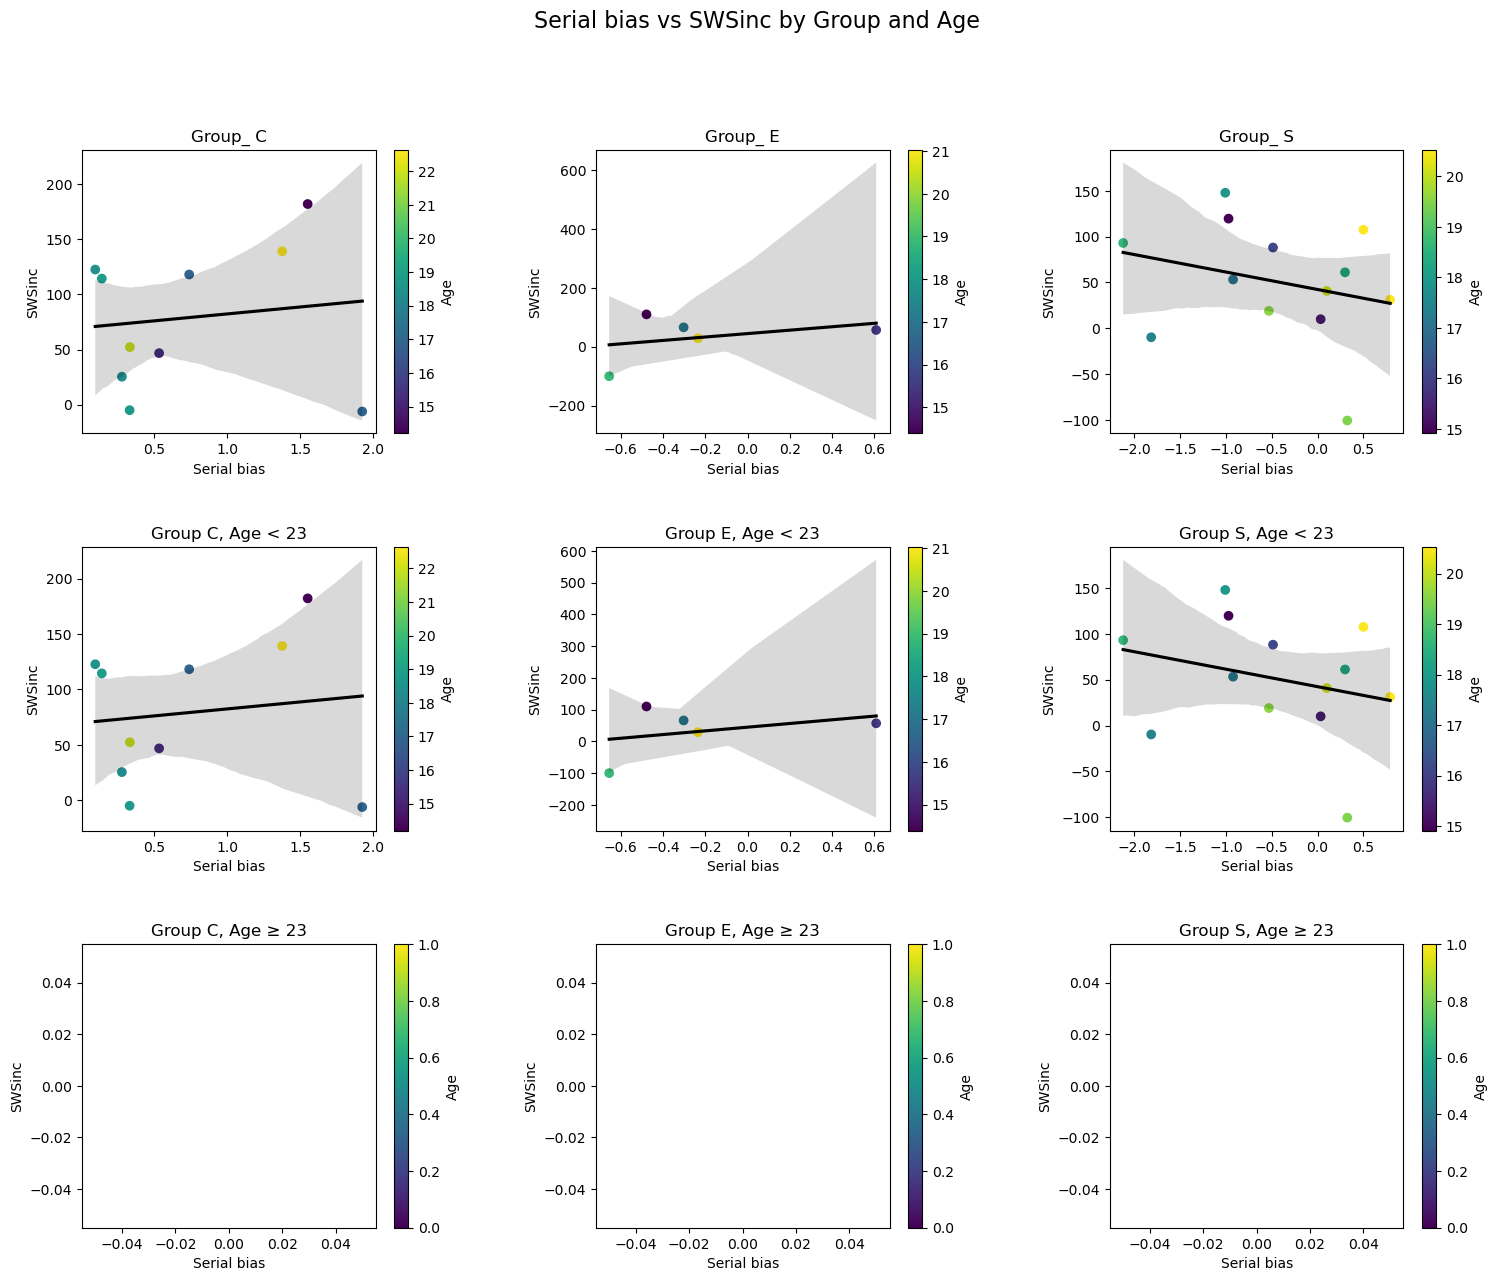

In [63]:

groups = df_serial_age['Group_x'].unique()
age_ranges = [(None, 23), (23, None)]  # (<20, >=20)


fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i, group in enumerate(groups):
    ax = axes[0, i]
    group_data = df_serial_age[df_serial_age['Group_x'] == group]
    scatter = ax.scatter(group_data['SB'], group_data['SWSinc'], c=group_data['Age_x'], cmap='viridis')
    sns.regplot(x='SB', y='SWSinc', data=group_data, scatter=False, color='black', ax=ax)
    ax.set_title(f'Group_ {group}')
    ax.set_xlabel('Serial bias')
    ax.set_ylabel('SWSinc')
    fig.colorbar(scatter, ax=ax, label='Age')


for i, group in enumerate(groups):
    for j, (min_age, max_age) in enumerate(age_ranges):
        ax = axes[j + 1, i]
        if min_age is None:
            age_filtered_data = df_serial_age[(df_serial_age['Group_x'] == group) & (df_serial_age['Age_x'] < max_age)]
            age_label = f'< {max_age}'
        else:
            age_filtered_data = df_serial_age[(df_serial_age['Group_x'] == group) & (df_serial_age['Age_x'] >= min_age)]
            age_label = f'≥ {min_age}'

        scatter = ax.scatter(age_filtered_data['SB'], age_filtered_data['SWSinc'], c=age_filtered_data['Age_x'], cmap='viridis')
        sns.regplot(x='SB', y='SWSinc', data=age_filtered_data, scatter=False, color='black', ax=ax)
        ax.set_title(f'Group {group}, Age {age_label}')
        ax.set_xlabel('Serial bias')
        ax.set_ylabel('SWSinc')
        fig.colorbar(scatter, ax=ax, label='Age')

plt.suptitle('Serial bias vs SWSinc by Group and Age', fontsize=16)
plt.show()

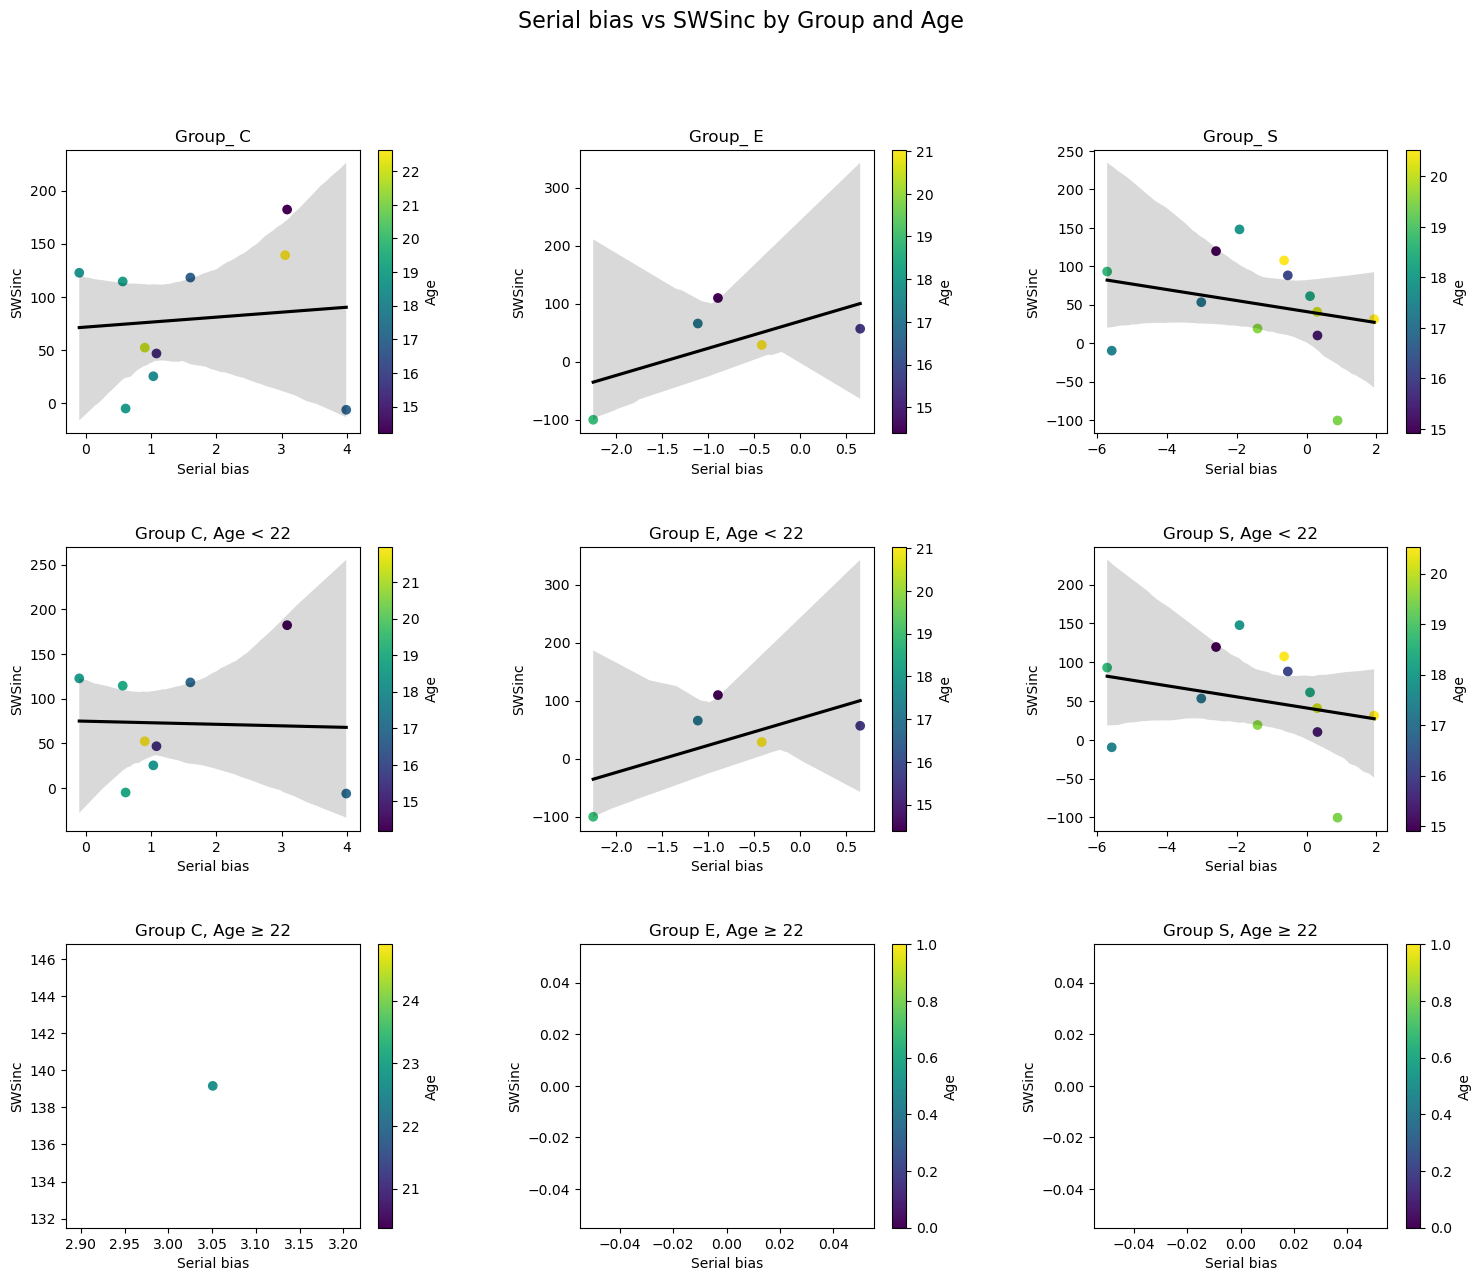

In [64]:

age_ranges = [(None, 22), (22, None)]  # (<20, >=20)


fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i, group in enumerate(groups):
    ax = axes[0, i]
    group_data = df_serial_age[df_serial_age['Group_x'] == group]
    scatter = ax.scatter(group_data['SB_par'], group_data['SWSinc'], c=group_data['Age_x'], cmap='viridis')
    sns.regplot(x='SB_par', y='SWSinc', data=group_data, scatter=False, color='black', ax=ax)
    ax.set_title(f'Group_ {group}')
    ax.set_xlabel('Serial bias')
    ax.set_ylabel('SWSinc')
    fig.colorbar(scatter, ax=ax, label='Age')


for i, group in enumerate(groups):
    for j, (min_age, max_age) in enumerate(age_ranges):
        ax = axes[j + 1, i]
        if min_age is None:
            age_filtered_data = df_serial_age[(df_serial_age['Group_x'] == group) & (df_serial_age['Age_x'] < max_age)]
            age_label = f'< {max_age}'
        else:
            age_filtered_data = df_serial_age[(df_serial_age['Group_x'] == group) & (df_serial_age['Age_x'] >= min_age)]
            age_label = f'≥ {min_age}'

        scatter = ax.scatter(age_filtered_data['SB_par'], age_filtered_data['SWSinc'], c=age_filtered_data['Age_x'], cmap='viridis')
        sns.regplot(x='SB_par', y='SWSinc', data=age_filtered_data, scatter=False, color='black', ax=ax)
        ax.set_title(f'Group {group}, Age {age_label}')
        ax.set_xlabel('Serial bias')
        ax.set_ylabel('SWSinc')
        fig.colorbar(scatter, ax=ax, label='Age')

plt.suptitle('Serial bias vs SWSinc by Group and Age', fontsize=16)
plt.show()

In [65]:
df_serial_age = df_serial_age[df_serial_age['group']=='E']

plt.scatter(df_serial_age['SB_par'], df_serial_age['s_slope'], c=df_serial_age['Age'], cmap='viridis')
plt.colorbar(label='Age')
sns.regplot(x='SB_par', y='s_slope', data=df_serial_age, scatter=False, color='black')

plt.xlabel('Serial bias')
plt.ylabel('Slow wave slope slope')
plt.title('Serial bias vs SWSlope_Slope')

KeyError: 's_slope'

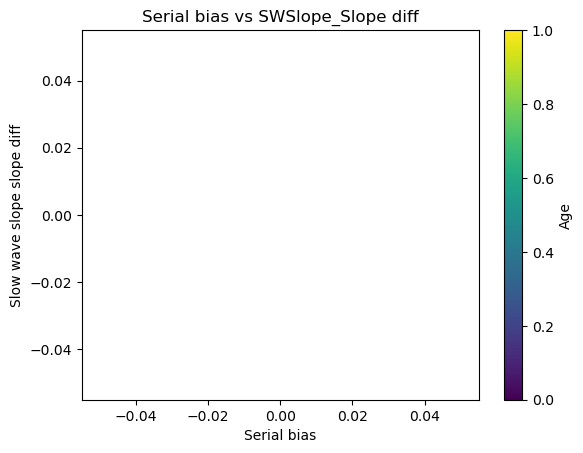

In [ ]:
df_serial_age['slope_diff'] = (
    df_serial_age['s_slope'] - (total_coefs[2] - total_coefs[3] * np.exp(-df_serial_age['Age'] / total_coefs[4])) 
)
import seaborn as sns

plt.scatter(df_serial_age['SB'], df_serial_age['slope_diff'], c=df_serial_age['Age'], cmap='viridis')
plt.colorbar(label='Age')
sns.regplot(x='SB', y='slope_diff', data=df_serial_age, scatter=False, color='black')

plt.xlabel('Serial bias')
plt.ylabel('Slow wave slope slope diff')
plt.title('Serial bias vs SWSlope_Slope diff')
plt.show()